In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.feature_selection import SelectFromModel
from gensim.models import Word2Vec
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [98]:
train_df = pd.read_csv("movie_ratings_train.csv")
test_df = pd.read_csv("movie_ratings_test.csv")
movies_df = pd.read_csv("movies.csv")

In [99]:
# Check for duplicates in the training dataset
train_duplicates = train_df.duplicated()
print("Duplicate rows in training data:")
print(train_duplicates.value_counts())

Duplicate rows in training data:
False    90836
Name: count, dtype: int64


In [100]:
# Concatenating the datasets
full_df = pd.concat([train_df, test_df], ignore_index=True)

# View the combined data
full_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,81834,NaN,1493846730
100832,610,87232,NaN,1493845469
100833,610,91500,NaN,1493845427
100834,610,91658,NaN,1493845240


In [101]:
# Extract the movie name
movies_df['moviename'] = movies_df['title'].str.extract(r'^(.*?)(?:\s\((\d{4}(?:–\d{4})?)\))?$')[0]

# Extract the first year (only the first four digits if a range exists)
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})')[0]
movies_df.head()


,movieId,title,genres,moviename,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [102]:
movies_df[movies_df["year"].isnull()]

,movieId,title,genres,moviename,year
6059,40697,Babylon 5,Sci-Fi,Babylon 5,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN
9091,143410,Hyena Road,(no genres listed),Hyena Road,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),The Adventures of Sherlock Holmes and Doctor W...,NaN
9179,149334,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN
9259,156605,Paterson,(no genres listed),Paterson,NaN
9367,162414,Moonlight,Drama,Moonlight,NaN
9448,167570,The OA,(no genres listed),The OA,NaN
9514,171495,Cosmos,(no genres listed),Cosmos,NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN


In [103]:
movie_dict = {
    "Babylon 5":  1994,
    "Ready Player One": 2018,
    "Hyena Road": 2015,
    "The Adventures of Sherlock Holmes and Doctor Watson": 1979,
    "Nocturnal Animals": 2016,
    "Paterson": 2016,
    "Moonlight": 2016,
    "The OA": 1990,
    "Cosmos": 2019,
    "Maria Bamford: Old Baby": 2017,
    "Generation Iron 2": 2017,
    "Black Mirror": 2018,
}

In [104]:
# Replace missing years using the dictionary
movies_df['year'] = movies_df['moviename'].map(movie_dict).fillna(movies_df['year'])

# Convert Year to integers (replace NaN first, if necessary)
movies_df['year'] = movies_df['year'].astype(int)

In [105]:
# index = movies_df[movies_df["genres"]=="(no genres listed)"].index
# movies_df.loc[index]

In [106]:
movies_df.head()

,movieId,title,genres,moviename,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [107]:
merged_df = pd.merge(full_df, movies_df, on ='movieId', how='left') 

merged_df.head()

,userId,movieId,rating,timestamp,title,genres,moviename,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,Heat,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en),1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The",1995


In [108]:

merged_df.drop(columns=['title', 'timestamp'], inplace= True, axis= 1 )


In [109]:
merged_df.head()

,userId,movieId,rating,genres,moviename,year
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,1,3,4.0,Comedy|Romance,Grumpier Old Men,1995
2,1,6,4.0,Action|Crime|Thriller,Heat,1995
3,1,47,5.0,Mystery|Thriller,Seven (a.k.a. Se7en),1995
4,1,50,5.0,Crime|Mystery|Thriller,"Usual Suspects, The",1995


In [110]:
merged_df.isnull().sum()

userId           0
movieId          0
rating       10000
genres           0
moviename        0
year             0
dtype: int64

In [111]:
# Word2Vec for moviename
merged_df['moviename_tokens'] = merged_df['moviename'].str.lower().str.split()
merged_df['genres_tokens'] = merged_df['genres'].str.lower().str.split()
sentences = merged_df['moviename_tokens'].tolist() + merged_df['genres_tokens'].tolist()
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)
# 100
# Aggregate embeddings for each record
def aggregate_embeddings(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:  # Check if the list is not empty
        return np.mean(vectors, axis=0)  # Aggregate using mean
    else:
        return np.zeros(model.vector_size)  # Handle cases where no tokens are in the model

merged_df['moviename_embedding'] = merged_df['moviename_tokens'].apply(lambda tokens: aggregate_embeddings(tokens, model))
merged_df['genres_embedding'] = merged_df['genres_tokens'].apply(lambda tokens: aggregate_embeddings(tokens, model))

# Convert embeddings to separate DataFrame
embedding_columns = ['embedding_' + str(i) for i in range(model.vector_size)]
moviename_embeddings_df = pd.DataFrame(merged_df['moviename_embedding'].tolist(), columns=['moviename_' + col for col in embedding_columns])
genres_embeddings_df = pd.DataFrame(merged_df['genres_embedding'].tolist(), columns=['genres_' + col for col in embedding_columns])

# Combine embeddings with original numerical columns
combined_df = pd.concat([merged_df[['rating', 'year']], moviename_embeddings_df, genres_embeddings_df], axis=1)


display(combined_df)


,rating,year,moviename_embedding_0,moviename_embedding_1,moviename_embedding_2,moviename_embedding_3,moviename_embedding_4,moviename_embedding_5,moviename_embedding_6,moviename_embedding_7,...,genres_embedding_40,genres_embedding_41,genres_embedding_42,genres_embedding_43,genres_embedding_44,genres_embedding_45,genres_embedding_46,genres_embedding_47,genres_embedding_48,genres_embedding_49
0,4.0,1995,-0.500766,-0.558197,1.203218,-0.657845,0.307278,0.563065,0.079114,2.954412,...,-0.018801,0.002356,-0.007500,-0.005103,0.011570,0.007101,0.003642,-0.002748,0.019755,0.000573
1,4.0,1995,-0.389388,-0.809447,-0.645831,0.392746,-0.389066,-0.583842,0.420488,1.493850,...,-0.009019,0.011403,0.018360,-0.008200,0.015929,0.010751,0.011758,0.001025,0.016426,-0.014038
2,4.0,1995,-0.025372,-0.133230,-0.163769,0.164692,0.030134,-0.087218,0.116619,0.317673,...,-0.004797,0.007258,-0.000199,-0.002403,-0.002111,-0.003343,0.001210,0.008330,-0.008506,-0.007667
3,5.0,1995,0.593830,-0.007297,0.017000,0.937083,-1.028247,-0.889516,2.214965,0.828834,...,-0.019312,-0.005038,-0.005106,0.007517,0.017841,0.003992,-0.004223,0.005939,-0.013607,-0.002587
4,5.0,1995,-0.024548,-0.159376,0.105380,1.168633,-1.191806,0.487639,0.722280,1.035576,...,0.009622,-0.001784,0.014545,-0.012073,-0.000196,-0.000175,-0.017085,0.017479,-0.004209,0.012870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,NaN,2010,0.439580,-0.271633,-0.099000,1.367183,-1.566219,0.611124,1.570695,0.572568,...,-0.001752,-0.005704,-0.006206,0.000346,0.008559,-0.001539,-0.016303,-0.003729,0.018166,0.016835
100832,NaN,2011,-0.221062,-1.005719,0.603326,-0.193759,-0.065261,0.695851,0.810636,1.100036,...,0.009438,-0.015762,-0.009580,-0.012269,0.009654,-0.012015,0.005676,-0.017649,0.004790,0.011387
100833,NaN,2012,-0.331487,-0.266906,0.238048,1.199523,-1.165399,0.535785,0.621475,0.756202,...,-0.013432,0.016203,-0.013717,-0.003693,-0.006905,0.007682,0.017574,-0.002179,-0.000871,0.007421
100834,NaN,2011,-0.489144,0.302116,-0.548284,0.679448,-0.202590,-0.024988,0.827690,0.995169,...,-0.017954,0.017184,0.008094,0.014939,0.019493,-0.014579,-0.018080,0.011672,0.018782,0.007014


In [112]:
condition = combined_df['rating'].isnull()

In [113]:
train_data = combined_df[~condition]

test_data = combined_df[condition]

In [114]:
X = train_data.drop(columns=['rating'])  
y = train_data['rating']  

In [115]:
# Step 1: Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
test_data.drop(columns="rating", axis=1, inplace=True)

C:\Users\ekf98\AppData\Local\Temp\ipykernel_17016\4206477509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns="rating", axis=1, inplace=True)


# Model One: Random Forest

In [117]:
# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Step 3: Predict on the training set
y_train_pred = model.predict(X_train)

# Step 4: Predict on the validation set
y_val_pred = model.predict(X_valid)

# Step 5: Calculate the MSE
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_valid, y_val_pred)

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Training MSE: 0.7578707649878681
Validation MSE: 0.9321168167086185


In [118]:
# Step 4: Predict on the validation set
y_pred_test = model.predict(test_data)

rounded_test_predictions = y_pred_test.tolist()

# Print the final binary predictions
print(rounded_test_predictions)

[3.6604883519078077, 3.3608306074305307, 3.4151895839748803, 4.240377711856077, 4.163170582118695, 3.9544342808567445, 3.967333365537006, 4.008010483243401, 3.564765445026988, 3.361767261136526, 3.6990975917927558, 3.8215155901148, 3.307390556795895, 3.677220473198734, 4.207962040849459, 3.7997313524642298, 3.1407322315916746, 3.166954986036783, 3.9655930013792853, 3.8236217772954175, 4.3351030197308935, 3.466894788882487, 3.294897895330548, 3.7338603979384795, 4.048694163553103, 4.19800649672095, 3.4607093247237457, 3.3260575065097777, 3.850625009209353, 3.970633399622287, 3.9458075916170956, 3.945253875804097, 4.289962560937477, 4.084501169201852, 4.261833922161622, 4.086232948574358, 4.008010483243401, 3.528076403480583, 3.564765445026988, 4.14777516314423, 3.9270843001092, 3.8215155901148, 4.042286915794844, 4.013824643256489, 3.7997313524642298, 3.1984178710441866, 3.4111507460214296, 3.212489675990401, 3.553444373925873, 3.834958000691571, 4.186263347087766, 3.8368630790932055, 3

# Model Two: Neural Networks

Epoch 1/50


c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 167.4181 - mse: 167.4181 - val_loss: 1.0914 - val_mse: 1.0914
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1508 - mse: 1.1508 - val_loss: 1.2608 - val_mse: 1.2608
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2195 - mse: 1.2195 - val_loss: 2.2424 - val_mse: 2.2424
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3066 - mse: 1.3066 - val_loss: 2.5957 - val_mse: 2.5957
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4007 - mse: 1.4007 - val_loss: 1.6122 - val_mse: 1.6122
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3225 - mse: 1.3225 - val_loss: 1.1858 - val_mse: 1.1858
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2452 - mse: 1.2452 - val_loss: 1.1225 - val_mse: 1.1225
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1444 - mse: 1.1444 - val_loss: 1.0617 - val_mse: 1.0617
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2m

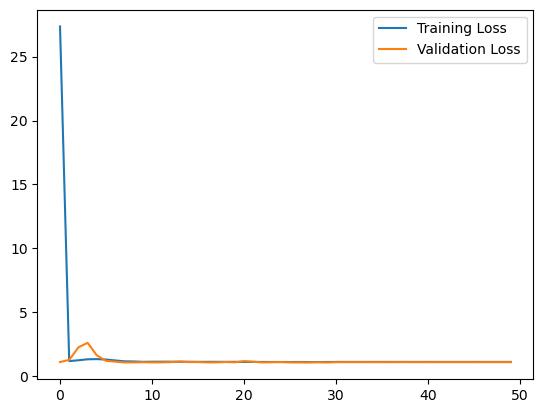

2271/2271 ━━━━━━━━━━━━━━━━━━━━ 2s 733us/step
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


In [119]:
# Create the single-layered neural network
# model = Sequential([
#     Dense(units=1, activation='linear', input_shape=(X_train.shape[1],))   
# ])

model = Sequential([
    Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(units=16, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train,  validation_data=(X_valid, y_valid), epochs=50, batch_size=50, verbose=1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#Predict on the training set
y_train_pred = model.predict(X_train)

# Make predictions
y_val_pred = model.predict(X_valid)

In [120]:
# Step 5: Calculate the MSE
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_valid, y_val_pred)

print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")

Training MSE: 1.101435122808114
Validation MSE: 1.0795924041512561


In [121]:
sorted(y_val_pred.tolist())

[[3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502170562744],
 [3.486502